In [28]:
import kagglehub

# Download dataset
path = kagglehub.dataset_download("arunrk7/surface-crack-detection")

print("Path to dataset files:", path)


Path to dataset files: C:\Users\Shakeel M. Shajahan\.cache\kagglehub\datasets\arunrk7\surface-crack-detection\versions\1


In [29]:
import os
import cv2
import matplotlib.pyplot as plt

# Path to Positive class
positive_dir = os.path.join(path, "Positive")
negative_dir = os.path.join(path, "Negative")

# List some files
print("Positive samples:", os.listdir(positive_dir)[:5])
print("Negative samples:", os.listdir(negative_dir)[:5])

Positive samples: ['00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg']
Negative samples: ['00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg']


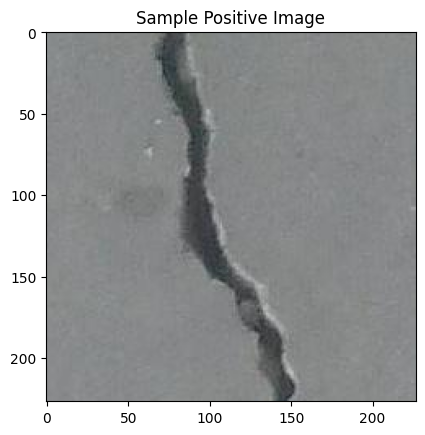

In [30]:
# Read an image
img_path = os.path.join(positive_dir, os.listdir(positive_dir)[0])
img = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Sample Positive Image")
plt.show()

In [31]:
import tensorflow as tf

# Collect file paths + labels
pos_files = tf.io.gfile.glob(os.path.join(positive_dir, "*"))
neg_files = tf.io.gfile.glob(os.path.join(negative_dir, "*"))

files  = tf.constant(pos_files + neg_files)
labels = tf.constant([1]*len(pos_files) + [0]*len(neg_files))

# Build dataset of (image, label)
def load_image(fp, label):
    img = tf.io.read_file(fp)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    return img, label

dataset = tf.data.Dataset.from_tensor_slices((files, labels))

In [32]:
def split_ds(dataset, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    n = len(dataset) 

    # Shuffle once
    ds = dataset.shuffle(buffer_size=n, seed=seed, reshuffle_each_iteration=False)

    # Sizes
    n_train = int(n * train_ratio)
    n_val   = int(n * val_ratio)
    n_test  = n - n_train - n_val

    # Slices
    ds_train = ds.take(n_train)
    ds_tmp   = ds.skip(n_train)
    ds_val   = ds_tmp.take(n_val)
    ds_test  = ds_tmp.skip(n_val)

    return ds_train, ds_val, ds_test


train_ratio=0.8
val_ratio=0.1
test_ratio=0.1
BATCH_SIZE = 32
SEED = 42

train_dataset, val_dataset, test_dataset = split_ds(dataset, train_ratio, val_ratio, test_ratio)

print("Length of dataset", len(dataset))
print("Length of train dataset", len(train_dataset))
print("Length of val dataset", len(val_dataset))
print("Length of test dataset", len(test_dataset))


Length of dataset 40000
Length of train dataset 32000
Length of val dataset 4000
Length of test dataset 4000


In [33]:
train_dataset


<_TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [34]:
# Use image_dataset_from_directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    labels="inferred",          # folder names: Positive / Negative
    label_mode="binary",        # binary classification
    image_size=(224, 224),      # resize to 224x224
    batch_size=32,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training"
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    path,
    labels="inferred",
    label_mode="binary",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation"
)

# Split 20% into 10% val + 10% test
val_batches = len(val_dataset)    # number of batches in val+test
half = val_batches // 2

val_ds  = val_dataset.take(half)
test_ds = val_dataset.skip(half)

# Print
print("Train batches:", len(train_ds))
print("Val batches:",   len(val_ds))
print("Test batches:",  len(test_ds))



Found 40000 files belonging to 2 classes.
Using 32000 files for training.
Found 40000 files belonging to 2 classes.
Using 8000 files for validation.
Train batches: 1000
Val batches: 125
Test batches: 125


In [35]:
# Normalize function
def normalize(img, label):
    img = tf.cast(img, tf.float32) / 255.0   # scale [0,255] → [0,1]
    return img, label

# Apply to all splits
train_ds = train_ds.map(normalize)
val_ds   = val_ds.map(normalize)
test_ds  = test_ds.map(normalize)

In [41]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomContrast, RandomRotation, Resizing, Rescaling

IM_SIZE = 224
KERNEL_SIZE = 5
N_STRIDES = 1
N_FILTERS = 6
POOL_SIZE = 2

model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = N_FILTERS , kernel_size = KERNEL_SIZE, strides = N_STRIDES , padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),

    Conv2D(filters = N_FILTERS*2 + 4, kernel_size = KERNEL_SIZE, strides=N_STRIDES, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),

    Flatten(),

    Dense( 100, activation = "relu"),
    BatchNormalization(),
    
    Dense( 10, activation = "relu"),
    BatchNormalization(),
    
    Dense( 1, activation = "sigmoid"),

])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 220, 220, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 220, 220, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 110, 110, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 106, 106, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 106, 106, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 53, 53, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 44944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100)            │     4,494,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,498,921 (17.16 MB)

 Trainable params: 4,498,657 (17.16 MB)

 Non-trainable params: 264 (1.03 KB)

In [42]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=BinaryCrossentropy(),
    metrics=[BinaryAccuracy()],
)

In [44]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1
)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 287s 286ms/step - binary_accuracy: 0.9971 - loss: 0.0105 - val_binary_accuracy: 0.9900 - val_loss: 0.0352
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 262s 262ms/step - binary_accuracy: 0.9970 - loss: 0.0104 - val_binary_accuracy: 0.9935 - val_loss: 0.0283
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 260s 260ms/step - binary_accuracy: 0.9977 - loss: 0.0078 - val_binary_accuracy: 0.9503 - val_loss: 0.1733
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 263s 263ms/step - binary_accuracy: 0.9973 - loss: 0.0085 - val_binary_accuracy: 0.8443 - val_loss: 1.1417
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 264s 264ms/step - binary_accuracy: 0.9989 - loss: 0.0044 - val_binary_accuracy: 0.9457 - val_loss: 0.4038
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 323s 265ms/step - binary_accuracy: 0.9984 - loss: 0.0055 - val_binary_accuracy: 0.9937 - val_loss: 0.0209
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 263s 263ms/step - binary_accuracy: 0.9984 - loss: 0.0061 - val_binary_

In [45]:
model.evaluate(test_ds)

125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - binary_accuracy: 0.9933 - loss: 0.0281


[0.02810489386320114, 0.9932500123977661]

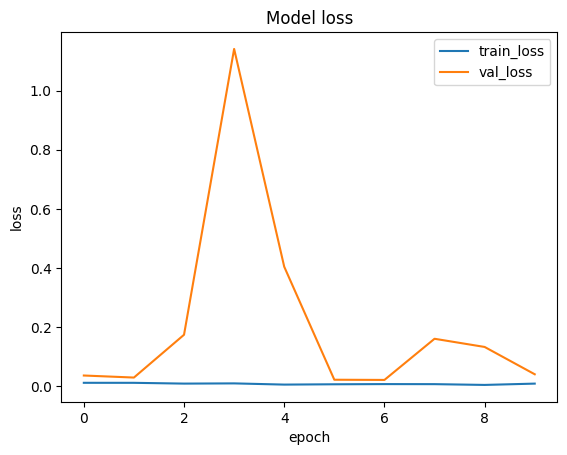

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [49]:
def crack_or_not(p):
    return "Crack" if p >= 0.5 else "No Crack"

# Get one batch from test dataset
for img, label in test_ds.take(1):
    pred = model.predict(img)   # shape (batch_size, 1)
    for i in range(len(img)):
        true_lbl = "Crack" if label[i].numpy() == 1 else "No Crack"
        pred_lbl = crack_or_not(pred[i][0])
        print(f"True: {true_lbl}, Pred: {pred_lbl} ({pred[i][0]:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
True: No Crack, Pred: No Crack (0.00)
True: No Crack, Pred: No Crack (0.00)
True: Crack, Pred: Crack (1.00)
True: No Crack, Pred: No Crack (0.00)
True: Crack, Pred: Crack (1.00)
True: No Crack, Pred: No Crack (0.00)
True: No Crack, Pred: No Crack (0.00)
True: Crack, Pred: Crack (1.00)
True: No Crack, Pred: No Crack (0.00)
True: Crack, Pred: Crack (1.00)
True: Crack, Pred: Crack (1.00)
True: Crack, Pred: Crack (1.00)
True: No Crack, Pred: No Crack (0.00)
True: No Crack, Pred: No Crack (0.00)
True: No Crack, Pred: No Crack (0.00)
True: Crack, Pred: Crack (1.00)
True: No Crack, Pred: No Crack (0.00)
True: Crack, Pred: Crack (1.00)
True: No Crack, Pred: No Crack (0.00)
True: No Crack, Pred: No Crack (0.00)
True: Crack, Pred: Crack (1.00)
True: Crack, Pred: Crack (1.00)
True: Crack, Pred: Crack (1.00)
True: No Crack, Pred: No Crack (0.00)
True: Crack, Pred: Crack (1.00)
True: Crack, Pred: Crack (1.00)
True: Crack, Pred: Crack (1.00)
True: No Crack, Pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


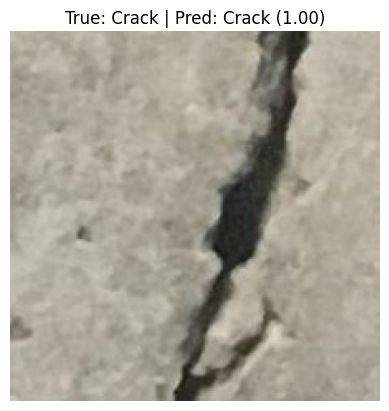

In [56]:
import numpy as np

for images, labels in test_ds.take(1):
    idx = np.random.randint(len(images))
    img = images[idx].numpy()   # keep float if normalized, uint8 if not
    
    true_lbl = "Crack" if labels[idx].numpy() == 1 else "No Crack"
    pred = model.predict(images[idx:idx+1])
    pred_lbl = "Crack" if pred[0][0] >= 0.5 else "No Crack"
    
    plt.imshow(img)   # don’t force uint8 unless your ds is unnormalized
    plt.title(f"True: {true_lbl} | Pred: {pred_lbl} ({pred[0][0]:.2f})")
    plt.axis("off")
    plt.show()
    break